## Fuente de datos
### MT560
* Recopilación de diferentes corpus en inglés a un idioma de destino.
* La recopilación de este corpus tiene las siguientes fuentes para diferentes idiomas, el resto de información puede ser encontrado en: [MTData.recipes](https://github.com/thammegowda/016-many-eng-v2/blob/2bf3e75ce/data/mtdata.recipes.yml)

| Fuentes |
|-------|
| JW300 |
| OPUS100  |
| OPUSGnome |
| OPUSUbuntu |
| OPUS-bibleuedin |
| OPUS-wikimedia |

## Construcción del Corpus
### Variantes del quechua

| ISO 639-3 | Nombre                                  | País      | Oraciones | Tokens    |
|-----------|-----------------------------------------|-----------|-----------|-----------|
| QUZ       | Cusco Quechua                           | Perú      | 127,408   | 1,649,454 |
| QUY       | Ayacucho Quechua                        | Perú      | 113,702   | 1,402,781 |
| QVI       | Imbabura Highland Quichua               | Ecuador   | 50,527    | 672,711   |
| QUG       | Chimborazo Highland Quichua             | Ecuador   | 20,272    | 247,947   |
| QUW       | Tena Lowland Quichua                    | Ecuador   | 15,674    | 292,905   |

### Otras lenguas indígenas

| ISO 639-3 | Nombre              | País             | Oraciones | Tokens    |
|-----------|---------------------|------------------|-----------|-----------|
| YUA       | Yucateco            | México           | 168,299   | 3,524,830 |
| GUG       | Paraguayan Guaraní  | Paraguay         | 143,391   | 2,151,216 |
| TZO       | Tzotzil             | México           | 140,124   | 2,993,791 |
| AYM       | Aymara              | Bolivia/Perú     | 138,760   | 1,939,507 |
| MRI       | Maori               | Nueva Zelanda    | 62,963    | 2,151,493 |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
basePath = "/content/drive/MyDrive/corpus_quechua"

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313509 sha256=ac0f87d4de112bf720d1c8fd48eaf3952bec89f38ccbca72b940e09e894cfa3f
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


## Load and clean data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
import re
import fasttext

model = fasttext.load_model(f"{basePath}/lid.176.bin")
df = pd.read_csv(f"{basePath}/filtered_corpus.csv")

spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))
spanish_words_from_wordnet = set(w for s in wordnet.all_synsets() for w in s.lemma_names('spa'))

tokenize = lambda x: word_tokenize(x)

original_sentences = []
removed_words = []

def filter_and_clean_spanish_words(sentence: str) -> str:
  words = sentence.split()
  filtered_words = []

  for word in words:
    is_spanish = False
    # print(f"word = {word} - ", end='')
    labels, probabilities = model.predict(words, threshold=0.99)
    for label, probability in zip(labels, probabilities):
      if len(label) > 0 and label[0] == '__label__es':
        # print(f"label = {label} - probability = {probability}")
        is_spanish =  True
        break
    if not is_spanish:
      original_sentences.append(sentence)
      removed_words.append(word)
      filtered_words.append(word)

  return " ".join(filtered_words)


def remove_invalid_sentences(sentence: str) -> str:
    words = sentence.split()
    cleaned_words = []
    for word in words:
        if len(word) == 1 and word == '\'':
            cleaned_words.append('')
        elif len(word) == 1 and word.isalpha():
            cleaned_words.append('')
        else:
            cleaned_words.append(word)
    return " ".join(cleaned_words).strip()

def remove_special_characters(text: str) -> str:
    return re.sub(r"[^a-záéíóúüñ' ]", "", text)

def remove_spaces(text: str) -> str:
    return re.sub(r"\s+", " ", text)

def to_lowercase(text: str) -> str:
  return str(text).lower()

def remove_es_stopwords(text: str) -> str:
  words = text.split()
  filtered_words = [word for word in words if word not in spanish_stopwords]
  return " ".join(filtered_words)

def remove_en_stopwords(text: str) -> str:
  words = text.split()
  filtered_words = [word for word in words if word not in spanish_stopwords]
  return " ".join(filtered_words)

def set_empty_str_to_nan(text: str) -> str:
  if pd.isna(text) or text.strip() == '':
        return np.nan
  return text

df["Sentence"] = df["Sentence"].apply(remove_special_characters)
df["Sentence"] = df["Sentence"].apply(remove_spaces)
df["Sentence"] = df["Sentence"].apply(to_lowercase)
df["Sentence"] = df["Sentence"].apply(remove_es_stopwords)
df["Sentence"] = df["Sentence"].apply(remove_en_stopwords)
df["Sentence"] = df["Sentence"].apply(remove_special_characters)
df["Sentence"] = df["Sentence"].apply(filter_and_clean_spanish_words)
df["Sentence"] = df["Sentence"].apply(remove_invalid_sentences)
df["Sentence"] = df["Sentence"].apply(remove_spaces)
df["Sentence"] = df["Sentence"].apply(set_empty_str_to_nan)

# Filtrar solo para Quechua
quechua_langs = ["quz", "quy", "qvi", "qug", "quw"]
df = df[df['ISO'].isin(quechua_langs)]
df = df[df['Sentence'].notna()]

# One hot
df = pd.get_dummies(df, columns=['ISO'], prefix='', prefix_sep='')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
removed_df = pd.DataFrame({"Original_Sentence": original_sentences, "Removed_Spanish_Words": removed_words})
print(removed_df.head())

                                   Original_Sentence Removed_Spanish_Words
0                                 allinta uyariychis               allinta
1                                 allinta uyariychis            uyariychis
2  che ru oipota opavave oikuaáva pe tarape ojero...                   che
3  che ru oipota opavave oikuaáva pe tarape ojero...                    ru
4  che ru oipota opavave oikuaáva pe tarape ojero...                oipota


In [ ]:
removed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12067274 entries, 0 to 12067273
Data columns (total 2 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   Original_Sentence      object
 1   Removed_Spanish_Words  object
dtypes: object(2)
memory usage: 184.1+ MB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312510 entries, 0 to 981109
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  312510 non-null  object
 1   qug       312510 non-null  bool  
 2   quw       312510 non-null  bool  
 3   quy       312510 non-null  bool  
 4   quz       312510 non-null  bool  
 5   qvi       312510 non-null  bool  
dtypes: bool(5), object(1)
memory usage: 6.3+ MB


In [ ]:
df.head()

,Sentence,qug,quw,quy,quz,qvi
0,allinta uyariychis,False,False,False,True,False
12,llaqtaykin llaqtay kanqa diosniykin diosniy kanqa,False,False,False,True,False
13,mamay ratollachu kutimunki,False,False,False,True,False
16,paqarisnintaq moisesqa llaqtata nirqan anchata...,False,False,False,True,False
20,sumaq sonqo kayniykichisqa lliw runakunaq reqs...,False,False,False,True,False


In [ ]:
df[quechua_langs].sum()

,0
quz,123347
quy,110397
qvi,44733
qug,18653
quw,15380


In [ ]:
df.to_csv((f"{basePath}/quechua_labeled_corpus.csv"), index=False, encoding="utf-8")

In [ ]:
df_labeled_quechua = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv", encoding="utf-8")

In [ ]:
df_labeled_quechua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312510 entries, 0 to 312509
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  312510 non-null  object
 1   qug       312510 non-null  bool  
 2   quw       312510 non-null  bool  
 3   quy       312510 non-null  bool  
 4   quz       312510 non-null  bool  
 5   qvi       312510 non-null  bool  
dtypes: bool(5), object(1)
memory usage: 3.9+ MB


## Red Neuronal Profunda

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Model
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=93c469693d343e9daee4434c8b843535bbeaae4f480c5ce9a9ad1dd522fecc0d
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
!pip install fasttext

--2025-05-30 22:30:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.qu.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.132.81, 18.173.132.6, 18.173.132.17, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.132.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451549616 (2.3G) [application/octet-stream]
Saving to: ‘cc.qu.300.bin.gz’

cc.qu.300.bin.gz    100%[===================>]   2.28G   267MB/s    in 10s     

2025-05-30 22:30:24 (234 MB/s) - ‘cc.qu.300.bin.gz’ saved [2451549616/2451549616]

gzip: cc.qu.300.bin already exists; do you wish to overwrite (y or n)? y


In [ ]:
import fasttext
fasttext_model = fasttext.load_model(f"{basePath}/cc.qu.300.bin")

In [ ]:
def get_sentence_embedding(text: str) -> np.ndarray:
    if pd.isna(text):
        return np.zeros(300)
    words = word_tokenize(text)
    embeddings = [fasttext_model.get_word_vector(word) for word in words if word]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

In [ ]:
df_quechua = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv")

In [ ]:
df_quechua.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326572 entries, 0 to 326571
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  326572 non-null  object
 1   qug       326572 non-null  bool  
 2   quw       326572 non-null  bool  
 3   quy       326572 non-null  bool  
 4   quz       326572 non-null  bool  
 5   qvi       326572 non-null  bool  
dtypes: bool(5), object(1)
memory usage: 4.0+ MB


In [ ]:
# X = df_quechua['Sentence']
X = np.array([get_sentence_embedding(text) for text in df_quechua['Sentence']])
y = df_quechua[['quz', 'quy', 'qvi', 'qug', 'quw']].values

In [ ]:
# vectorizer = TfidfVectorizer(max_features=1000)
# X_tfidf = vectorizer.fit_transform(X).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class QuechuaNN(Model):
    def __init__(self):
        super(QuechuaNN, self).__init__()
        self.fc1 = Dense(128, activation='relu', input_shape=(300,))
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(5, activation='softmax')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
model = QuechuaNN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7486 - loss: 0.5894 - val_accuracy: 0.8506 - val_loss: 0.3632
Epoch 2/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8576 - loss: 0.3449 - val_accuracy: 0.8736 - val_loss: 0.3124
Epoch 3/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8741 - loss: 0.3037 - val_accuracy: 0.8846 - val_loss: 0.2867
Epoch 4/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8842 - loss: 0.2797 - val_accuracy: 0.8894 - val_loss: 0.2669
Epoch 5/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8912 - loss: 0.2594 - val_accuracy: 0.8911 - val_loss: 0.2623
Epoch 6/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8984 - loss: 0.2462 - val_accuracy: 0.9006 - val_loss: 0.2445
Epoch 7/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9023 - loss: 0.2333 - val_accuracy: 0.8953 - val_loss: 0.2510
Epoch 8/20
6532/6532 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9058 - loss: 0

Test Accuracy: 0.9102
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


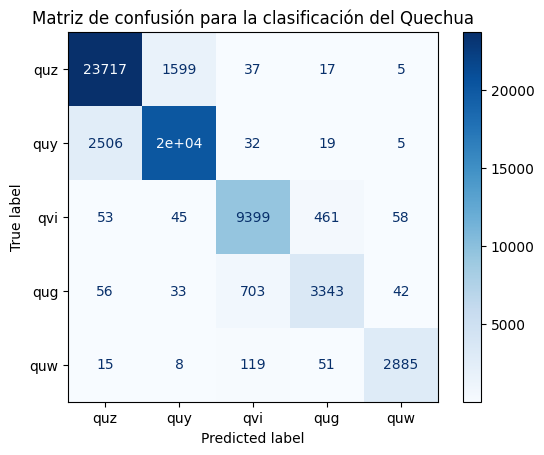

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['quz', 'quy', 'qvi', 'qug', 'quw'])
disp.plot(cmap='Blues')
plt.title('Matriz de confusión para la clasificación del Quechua')
plt.show()

In [ ]:
variances = np.var(y_pred, axis=0)
class_labels = ['quz', 'quy', 'qvi', 'qug', 'quw']

print("Varianza de las probabilidades predichas por clase:")
for label, variance in zip(class_labels, variances):
    print(f"Clase {label}: {variance:.6f}")

## DeBERTa

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import DebertaConfig, DebertaModel, DebertaTokenizer
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn as nn

class QuechuaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = torch.tensor(dataframe[['qug', 'quw', 'quy', 'quz', 'qvi']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = str(self.data.iloc[idx]['Sentence'])  # Ensure sentence is string
        encoding = self.tokenizer(
            sentence,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': self.labels[idx]
        }

# Load your dataset from CSV
df_quechua = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv")
dataset = df_quechua

# Load DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

# Create PyTorch dataset
quechua_dataset = QuechuaDataset(dataset, tokenizer, max_length=64)

# DataLoader setup
dataloader = DataLoader(quechua_dataset, batch_size=8, shuffle=True)

# DeBERTa config and base model
# config = DebertaConfig.from_pretrained("microsoft/deberta-base")
# base_model = DebertaModel(config)

config = DebertaConfig(
    hidden_size=384,   # Reduced from 768
    num_attention_heads=6,  # Reduced from 12 (head size = 384/6 = 64)
    num_hidden_layers=6,    # Reduced from 12 for efficiency
    intermediate_size=1536, # Reduced from 3072 (4x hidden_size)
    max_position_embeddings=64,  # Match reduced sequence length
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
base_model = DebertaModel(config)

# Classification head wrapper
class DebertaClassifier(nn.Module):
    def __init__(self, base_model, config, num_labels=5):
        super().__init__()
        self.deberta = base_model
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss()  # Binary cross-entropy for multi-label
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

# Model instantiation
model = DebertaClassifier(base_model, config, num_labels=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(3):  # Adjust epochs as needed
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    total_loss = 0
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} average loss: {total_loss/len(dataloader):.4f}")

# Save model
os.makedirs("./deberta-trained", exist_ok=True)
torch.save(model.state_dict(), "./deberta-trained/pytorch_model.bin")
config.save_pretrained("./deberta-trained")
tokenizer.save_pretrained("./deberta-trained")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Epoch 1:  13%|█▎        | 4931/39064 [1:44:06<12:00:40,  1.27s/it, loss=0.0567]


KeyboardInterrupt: 